In [3]:
# brew install libomp
# pip install lightgbm

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Correlation analysis

In [51]:
df = pd.read_csv('./data/output/result_gemeente_cleaned.csv')

In [52]:
df['gemiddeld huishoudinkomen'].head()

0    29000.0
1    34700.0
2    37100.0
3    29700.0
4    45500.0
Name: gemiddeld huishoudinkomen, dtype: float64

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6505 entries, 0 to 6504
Data columns (total 70 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           6505 non-null   int64  
 1   last_scraped                 6505 non-null   object 
 2   host_id                      6505 non-null   int64  
 3   host_since                   6505 non-null   object 
 4   host_is_superhost            6505 non-null   int64  
 5   neighbourhood_cleansed       6505 non-null   object 
 6   host_listings_count          6505 non-null   int64  
 7   latitude                     6505 non-null   float64
 8   longitude                    6505 non-null   float64
 9   property_type                6505 non-null   object 
 10  room_type                    6505 non-null   object 
 11  accommodates                 6505 non-null   int64  
 12  bathrooms                    6505 non-null   float64
 13  bathrooms_text    

## 1. Correlation of Columns with Price

In [54]:
# One hot encoding for property category
df = pd.get_dummies(df, columns=['property_category'], prefix=['type'])

In [49]:
features = ["host_is_superhost", "type_PRIVATE_ROOM", "type_WHOLE_PROPERTY", "accommodates", "bathrooms", "bedrooms", "beds",
            "number_of_reviews", "review_scores_rating", 'Dishwasher', 'Washer', 'Dryer', 'Microwave',
            'Freezer', 'Private entrance', 'Coffee maker', 'Oven', 'Outdoor dining area', 'Private patio or balcony',
            'Luggage dropoff allowed', 'Bathtub', 'Blender', 'Paid parking on premises',
            'Air conditioning', 'Waterfront', 'Pets allowed', 'Canal view', 'Free parking on premises', 'Bikes', 'Safe',
            "inwoners", "gemiddeld huishoudinkomen", "gemiddelde woningwaarde", "supermarkt - afstand",
            'treinstation - afstand', 'attractiepark - afstand', 'zwembad - afstand', 'bioscoop - afstand', 'museum - afstand',
            'café - afstand', 'hotel - afstand', 'restaurant - afstand']

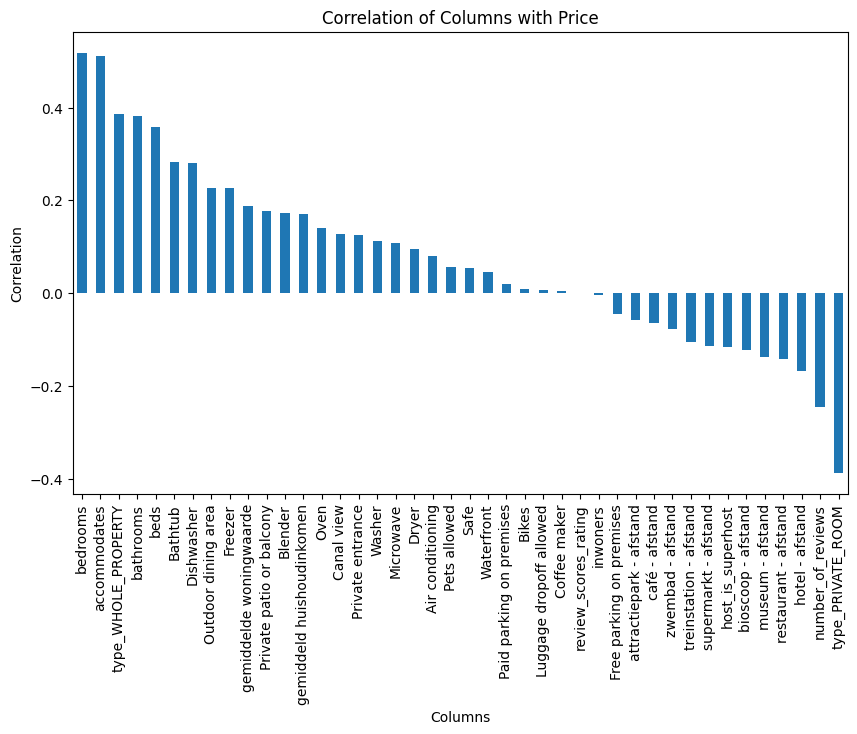

In [55]:
df_correlation = df[features]
corr_matrix = df_correlation.corr()

price_corr = df_correlation.corrwith(df['price']).sort_values(ascending=False)
price_corr.plot(kind='bar', figsize=(10, 6))
plt.title('Correlation of Columns with Price')
plt.ylabel('Correlation')
plt.xlabel('Columns')
plt.show()

## 2. Feature importance


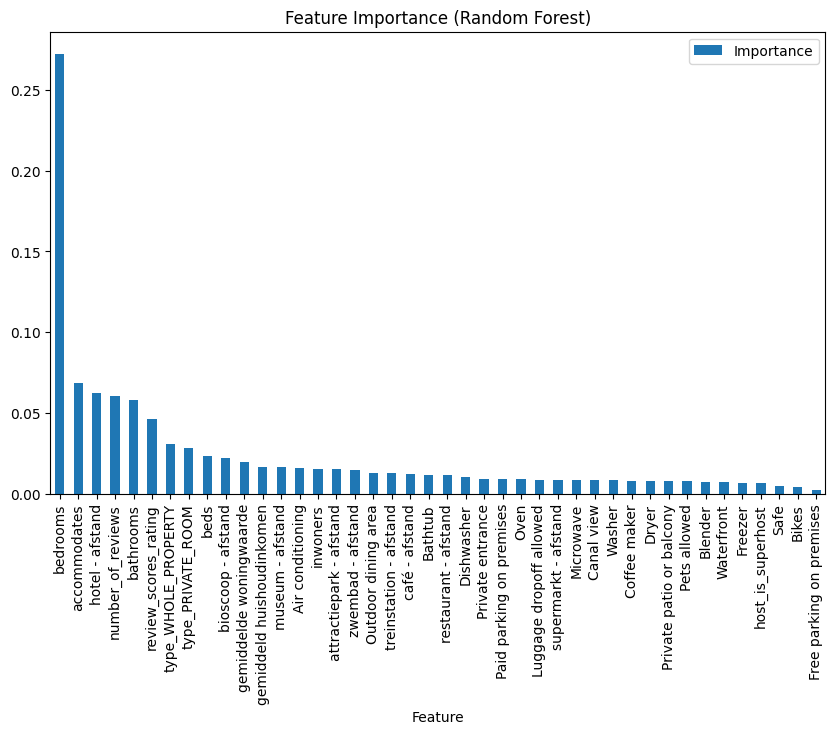

In [57]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor()
X = df[features]
y = df['price']

model.fit(X, y)
feature_importance = model.feature_importances_

feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

feature_importance_df.plot(kind='bar', x='Feature', y='Importance', figsize=(10, 6))
plt.title('Feature Importance (Random Forest)')
plt.show()

In [139]:
features = (["price", "host_is_superhost", "accommodates", "bathrooms", "bedrooms", "beds"
            , 'Dishwasher', 'Washer', 'Dryer', 'Microwave',
            'Freezer', 'Private entrance', 'Coffee maker', 'Oven', 'Outdoor dining area', 'Private patio or balcony',
            'Luggage dropoff allowed', 'Bathtub', 'Blender', 'Paid parking on premises',
            'Air conditioning', 'Waterfront', 'Pets allowed', 'Canal view', 'Free parking on premises', 'Bikes', 'Safe',
            "inwoners", "gemiddeld huishoudinkomen", "gemiddelde woningwaarde",
            "number_of_reviews", "review_scores_rating", "supermarkt - afstand",
            'treinstation - afstand', 'attractiepark - afstand', 'zwembad - afstand', 'bioscoop - afstand', 'museum - afstand',
            'café - afstand', 'hotel - afstand', 'restaurant - afstand', 'type_WHOLE_PROPERTY'])

 # "type_WHOLE_PROPERTY",  "type_PRIVATE_ROOM",

In [159]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# df1 = df[df["type_WHOLE_PROPERTY"] == 0]
df_clean = df[features]
df_clean = df_clean.dropna()
df_clean['log_price'] = np.log(df_clean['price'])

# Split the data into features (X) and target (y)
X = df_clean.drop(columns=['price', 'log_price'])
y = df_clean['log_price']

# 2. Split the Data into Training and Test Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Train the LightGBM Model

# Set up LightGBM dataset
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# Set parameters for the model
params = {
    'objective': 'regression',  # Since we are predicting a continuous value
    'metric': 'rmse',  # Root Mean Squared Error (RMSE)
    'boosting_type': 'gbdt',  # Gradient Boosting Decision Tree
    'num_leaves': 31,  # Number of leaves in one tree
    'learning_rate': 0.05,  # Learning rate
    'feature_fraction': 0.9  # Fraction of features to be used for building trees
}

# Train the model
lgb_model = lgb.train(params, train_data, valid_sets=[test_data], num_boost_round=200)

# 4. Make Predictions

# Predict on the test set
y_pred = lgb_model.predict(X_test, num_iteration=lgb_model.best_iteration,
                           callbacks=[
                               lgb.early_stopping(stopping_rounds=100),
                           ])

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001354 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 905
[LightGBM] [Info] Number of data points in the train set: 5199, number of used features: 41
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 5.432143
[LightGBM] [Warning] Unknown parameter: callbacks
[LightGBM] [Warning] Unknown parameter: object
[LightGBM] [Warning] Unknown parameter: 0x165dacb80>
[LightGBM] [Warning] Unknown parameter: at


In [160]:
# 5. Evaluate the Model

# Calculate RMSE
rmse = mean_squared_error(y_test, y_pred)
print(f'RMSE: {rmse}')

# Calculate R²
r2 = r2_score(y_test, y_pred)
print(f'R²: {r2}')

# Get number of observations (n) and number of features (p)
n = len(y_test)  # Number of samples
p = X_test.shape[1]  # Number of features (predictors)

# Calculate Adjusted R²
r2_adj = 1 - ((1 - r2) * (n - 1)) / (n - p - 1)

print(f'Adjusted R²: {r2_adj}')

RMSE: 0.0995176909730106
R²: 0.6269050334601951
Adjusted R²: 0.6147453405920457


In [142]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')


Mean Absolute Error: 0.24362478646336547


In [143]:
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 0.10056139722275943


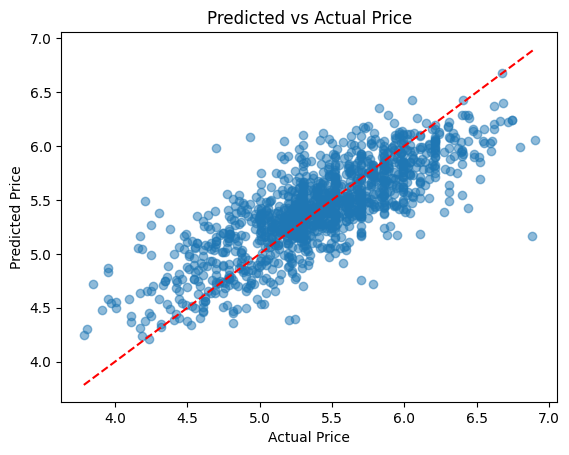

In [144]:
import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Predicted vs Actual Price')
plt.show()

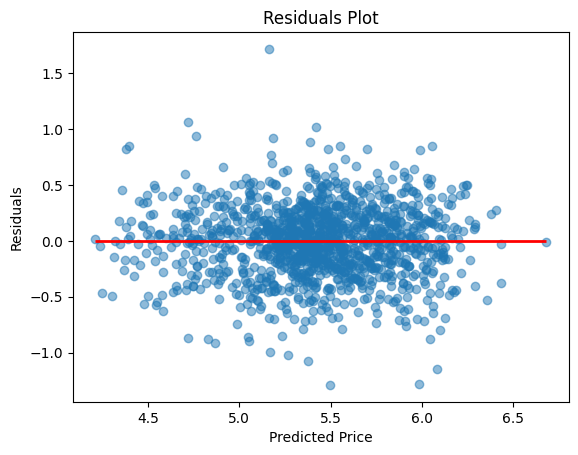

In [145]:
residuals = y_test - y_pred

plt.scatter(y_pred, residuals, alpha=0.5)
plt.hlines(y=0, xmin=y_pred.min(), xmax=y_pred.max(), colors='r', linewidth=2)
plt.xlabel('Predicted Price')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.show()

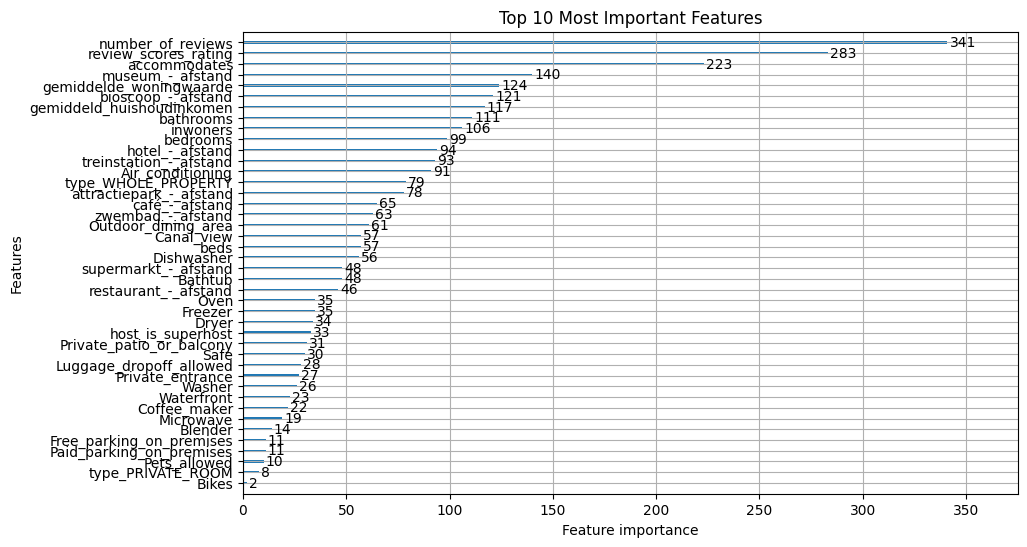

In [122]:
import lightgbm as lgb

lgb.plot_importance(lgb_model, max_num_features=100, importance_type='split', figsize=(10, 6))
plt.title('Top 10 Most Important Features')
plt.show()